In [1]:
import numpy as np
import pandas as pd
import os
import glob
from analysis_helper_exp3 import *
from IPython.display import clear_output
%load_ext autoreload
%autoreload 2
        
iter_max=50
task_col=None
cluster_col='BT_0.4 ID'

run_threshold=0
hs_params = 3
hs_job_count = hs_params*107*1

root_dir = '../../../aldd_results/aldd_exp_3_uncert_bonus/params_results\\'
hs_dir = glob.glob(root_dir+'sampled_hyparams/*/*/*/*/')

df_from_file = True

In [2]:
if not df_from_file:
    all_96_hs, all_384_hs, all_1536_hs, all_df_hs, successful_jobs, failed_jobs = get_results(hs_dir, iter_max, task_col, cluster_col, run_threshold, True)

    print('----------------------------------------------------------------------------')
    print('HS Jobs:')
    print('Total jobs: {}'.format(hs_job_count))
    print('Failed jobs: {}'.format(len(failed_jobs)))
    print('Successful jobs: {}'.format(len(successful_jobs)))

    hs_unique = np.unique(["_".join(x.split('_')[0:2]) for x in successful_jobs])
    print('Total HS: {}'.format(hs_params))
    print('Successful HS: {}'.format(len(hs_unique)))
else:
    all_96_hs = pd.read_csv('./exp3/exp3_bonus.csv.gz')

C:\Users\Moeman\Anaconda3\envs\thesis\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
recompute_task_info=False
if recompute_task_info:
    task_names = [r.split('\\')[-2][:-6] for r in glob.glob('../datasets/pcba/*_cv_96/')]
    task_hit_dict = {}
    for task_col in task_names:
        task_df = pd.concat([pd.read_csv(x) for x in glob.glob('../datasets/pcba/{}_cv_96/unlabeled_*.csv'.format(task_col))])
        cpd_count = task_df.shape[0]
        hit_limit = task_df[task_col].sum()
        unique_hit_limit = task_df[task_df[task_col] == 1][cluster_col].unique().shape[0]
        task_hit_dict[task_col] = (hit_limit, unique_hit_limit, cpd_count)
else:
    import pickle
    with open('task_info_dict.pickle', 'rb') as handle:
        task_hit_dict = pickle.load(handle)

In [4]:
des_cols = ['hs_id', 'rf_id', 'max_iter', 'exploitation_hits', 'exploration_hits', 'total_hits',
            'total_unique_hits', 'total_batch_size', 'hs_group', 'task_col']

cdf = all_96_hs[all_96_hs['rf_id'] == '0']

hit_limit_list = []
uhit_limit_list = []
cpd_count_list = []
for tcol in cdf['task_col'].tolist():
    a, b, c = task_hit_dict[tcol]
    hit_limit_list.append(a)
    uhit_limit_list.append(b)
    cpd_count_list.append(c)
    
cdf['hit_limit'] = hit_limit_list
cdf['unique_hit_limit'] = uhit_limit_list
cdf['cpd_count'] = cpd_count_list

task_info = cdf[['task_col', 'hit_limit', 'unique_hit_limit', 'cpd_count']].drop_duplicates()
task_info['active_ratio'] = np.around(100.0 * task_info['hit_limit'] / task_info['cpd_count'], decimals=2)
task_info['hit_limit'] = task_info['hit_limit'].astype(int)
full_task_info = task_info.copy()

C:\Users\Moeman\Anaconda3\envs\thesis\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\Moeman\Anaconda3\envs\thesis\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\Moeman\Anaconda3\envs\thesis\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [5]:
excluded_tasks = ['pcba-aid588342','pcba-aid1030', 'pcba-aid504332', 
                  'pcba-aid686979', 'pcba-aid686978']
full_cdf = cdf.copy()
cdf = full_cdf[~full_cdf['task_col'].isin(excluded_tasks)]
task_info = full_task_info[~full_task_info['task_col'].isin(excluded_tasks)]
sorted_task_info = task_info.sort_values('active_ratio')

---
# Summary per 10, 20, 30, 40, 50 iterations

In [26]:
def helper_agg(col):
    if col.name  in ['rf_id', 'task_col']:
        return '-'
    elif col.name in ['hs_id', 'hs_group']:
        return col.unique()[0]
    else:
        if '_std' in col.name:
            return col.std()
        else:
            return col.mean()

def get_last_iter_summary(results_df, iter_max, group_cols = ['hs_id', 'rf_id']):
    sdf1 = results_df[results_df['iter_num']==iter_max][des_cols]
    sdf1 = sdf1.groupby(group_cols).agg(helper_agg).sort_values('total_hits', ascending=False)
    sorted_hid_list = sdf1.index.tolist()

    sdf2 = results_df[results_df['iter_num']==iter_max][des_cols]
    sdf2 = sdf2[[c for c in sdf2.columns if ('_hits' in c or 'hs_id' in c or 'rf_id' in c)]]
    sdf2.columns = [c.replace('hits', 'std') for c in sdf2.columns]
    sdf2 = sdf2.groupby(group_cols).agg(helper_agg).loc[sorted_hid_list]

    sdf = pd.concat([sdf1, sdf2], axis=1)
    return sdf

In [27]:
cdf_without_inactives = cdf[cdf['rf_id'] != 'allinactive0']
max_iter_list = [9010, 9020, 9030, 9040, 9050]

for max_iter in max_iter_list:
    miter_summary = get_last_iter_summary(cdf_without_inactives, max_iter, ['hs_id'])
    miter_summary = miter_summary.drop(['rf_id', 'max_iter', 'total_batch_size', 'task_col', 'hs_group', 'exploitation_std', 'exploration_std'], axis=1)
    miter_summary.index.name = 'max_iter: {}'.format(max_iter)
    display(miter_summary)

,exploitation_hits,exploration_hits,total_hits,total_unique_hits,total_std,total_unique_std
max_iter: 9010,,,,,,
CBWS_609_qbc,0.0,93.529412,93.529412,74.019608,103.616076,85.775205
CBWS_609,0.0,89.519608,89.519608,68.843137,101.179356,81.484463
CBWS_609_uncert_normalized,0.0,84.088235,84.088235,69.490196,95.382513,83.777138


,exploitation_hits,exploration_hits,total_hits,total_unique_hits,total_std,total_unique_std
max_iter: 9020,,,,,,
CBWS_609_qbc,0.0,190.401961,190.401961,139.941176,209.323013,161.717320
CBWS_609,0.0,187.529412,187.529412,135.813725,211.754327,162.309186
CBWS_609_uncert_normalized,0.0,182.000000,182.000000,138.294118,196.090351,159.046577


,exploitation_hits,exploration_hits,total_hits,total_unique_hits,total_std,total_unique_std
max_iter: 9030,,,,,,
CBWS_609_qbc,0.0,273.950980,273.950980,193.941176,304.344625,225.195573
CBWS_609,0.0,273.931373,273.931373,193.088235,311.961513,233.280357
CBWS_609_uncert_normalized,0.0,266.833333,266.833333,194.882353,291.231971,226.031597


,exploitation_hits,exploration_hits,total_hits,total_unique_hits,total_std,total_unique_std
max_iter: 9040,,,,,,
CBWS_609,0.0,352.441176,352.441176,242.745098,404.346253,291.448234
CBWS_609_qbc,0.0,352.382353,352.382353,243.803922,398.510445,285.759750
CBWS_609_uncert_normalized,0.0,340.794118,340.794118,243.029412,378.577911,285.208191


,exploitation_hits,exploration_hits,total_hits,total_unique_hits,total_std,total_unique_std
max_iter: 9050,,,,,,
CBWS_609,0.0,423.588235,423.588235,287.127451,492.742343,344.557218
CBWS_609_qbc,0.0,417.598039,417.598039,284.931373,479.878579,334.959795
CBWS_609_uncert_normalized,0.0,408.862745,408.862745,285.656863,458.186136,335.492795


---
# Per task active ratio

In [29]:
cdf_without_inactives = cdf[cdf['rf_id'] != 'allinactive0']
n_bins = 8
tasks_per_bin = int(np.ceil(107/n_bins))
binned_tasks = []
iter_max = 9050
for i in range(n_bins):
    temp_df = sorted_task_info.iloc[tasks_per_bin*i:tasks_per_bin*(i+1),:]
    qualifying_tasks, bin_min, bin_max = temp_df['task_col'].tolist(), temp_df['active_ratio'].min(), temp_df['active_ratio'].max()
    ldf = cdf_without_inactives[cdf_without_inactives['task_col'].isin(qualifying_tasks)]
    bin_df = get_last_iter_summary(ldf, iter_max, ['hs_id'])
    bin_df.index.name = '{}%-to-{}% total: {} tasks'.format(bin_min, bin_max, len(qualifying_tasks))
    bin_df = bin_df.drop(['rf_id', 'max_iter', 'total_batch_size', 'task_col', 'hs_group', 'exploitation_std', 'exploration_std'], axis=1)
    binned_tasks.append(bin_df)
    display(binned_tasks[i])

,exploitation_hits,exploration_hits,total_hits,total_unique_hits,total_std,total_unique_std
0.01%-to-0.06% total: 14 tasks,,,,,,
CBWS_609_qbc,0.0,21.000000,21.000000,16.214286,13.231664,11.157464
CBWS_609,0.0,20.285714,20.285714,14.571429,14.018826,10.910223
CBWS_609_uncert_normalized,0.0,19.071429,19.071429,14.714286,11.796116,9.972490


,exploitation_hits,exploration_hits,total_hits,total_unique_hits,total_std,total_unique_std
0.07%-to-0.14% total: 14 tasks,,,,,,
CBWS_609_qbc,0.0,32.928571,32.928571,25.642857,23.558321,17.323204
CBWS_609,0.0,28.357143,28.357143,23.357143,24.988019,18.719004
CBWS_609_uncert_normalized,0.0,26.857143,26.857143,20.928571,20.572039,14.029991


,exploitation_hits,exploration_hits,total_hits,total_unique_hits,total_std,total_unique_std
0.15%-to-0.28% total: 14 tasks,,,,,,
CBWS_609,0.0,140.857143,140.857143,103.000000,61.620248,36.794648
CBWS_609_uncert_normalized,0.0,140.857143,140.857143,102.285714,71.871528,44.380225
CBWS_609_qbc,0.0,130.928571,130.928571,99.428571,69.227011,43.732956


,exploitation_hits,exploration_hits,total_hits,total_unique_hits,total_std,total_unique_std
0.29%-to-0.42% total: 14 tasks,,,,,,
CBWS_609_uncert_normalized,0.0,224.428571,224.428571,152.642857,133.374380,85.987125
CBWS_609_qbc,0.0,213.214286,213.214286,147.142857,138.720626,91.646358
CBWS_609,0.0,207.285714,207.285714,141.928571,148.937999,95.436217


,exploitation_hits,exploration_hits,total_hits,total_unique_hits,total_std,total_unique_std
0.44%-to-0.96% total: 14 tasks,,,,,,
CBWS_609,0.0,420.642857,420.642857,288.714286,195.255890,132.774203
CBWS_609_qbc,0.0,403.285714,403.285714,280.142857,184.108425,122.314133
CBWS_609_uncert_normalized,0.0,400.714286,400.714286,281.857143,181.628712,118.749806


,exploitation_hits,exploration_hits,total_hits,total_unique_hits,total_std,total_unique_std
1.06%-to-1.81% total: 14 tasks,,,,,,
CBWS_609,0.0,698.928571,698.928571,452.928571,281.694178,157.523851
CBWS_609_qbc,0.0,693.285714,693.285714,445.785714,273.555065,156.488967
CBWS_609_uncert_normalized,0.0,688.142857,688.142857,449.000000,281.853988,166.334233


,exploitation_hits,exploration_hits,total_hits,total_unique_hits,total_std,total_unique_std
1.9%-to-3.37% total: 14 tasks,,,,,,
CBWS_609,0.0,1061.000000,1061.000000,674.500000,416.732344,298.535850
CBWS_609_qbc,0.0,1050.785714,1050.785714,688.357143,371.521027,284.578935
CBWS_609_uncert_normalized,0.0,1009.500000,1009.500000,680.857143,340.460943,275.440028


,exploitation_hits,exploration_hits,total_hits,total_unique_hits,total_std,total_unique_std
3.79%-to-6.17% total: 4 tasks,,,,,,
CBWS_609,0.0,1780.75,1780.75,1375.25,105.991745,210.248068
CBWS_609_qbc,0.0,1739.75,1739.75,1306.25,126.000992,194.606226
CBWS_609_uncert_normalized,0.0,1642.50,1642.50,1326.25,124.135678,177.291427


---
# Compound comparison

In [30]:
import numpy as np
import pandas as pd
import os
import glob
from analysis_helper_exp3 import *
from IPython.display import clear_output
%load_ext autoreload
%autoreload 2
        
iter_max=50
task_col=None
cluster_col='BT_0.4 ID'

run_threshold=0
hs_params, benchmark_params, custom_params = 3, 4, 1
hs_job_count = hs_params*107*11
benchmark_job_count = benchmark_params*107*11
custom_job_count = custom_params*107*11

hs_ids = ['ClusterBasedWCSelector_609', 'MABSelector_exploitive']

root_dir = '../../../aldd_results/aldd_exp_3_uncert_bonus//params_results\\'
a_dir = glob.glob(root_dir+'sampled_hyparams/ClusterBasedWCSelector_609/*/*/*/')
b_dir = glob.glob(root_dir+'benchmarks/ClusterBasedWCSelector_609_uncert_normalized/*/*/*/')
c_dir = glob.glob(root_dir+'benchmarks/ClusterBasedWCSelector_609_qbc/*/*/*/')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
recompute_task_info=False
if recompute_task_info:
    task_names = [r.split('\\')[-2][:-6] for r in glob.glob('../datasets/pcba/*_cv_96/')]
    task_hit_dict = {}
    for task_col in task_names:
        task_df = pd.concat([pd.read_csv(x) for x in glob.glob('../datasets/pcba/{}_cv_96/unlabeled_*.csv'.format(task_col))])
        cpd_count = task_df.shape[0]
        hit_limit = task_df[task_col].sum()
        unique_hit_limit = task_df[task_df[task_col] == 1][cluster_col].unique().shape[0]
        task_hit_dict[task_col] = (hit_limit, unique_hit_limit, cpd_count)
else:
    import pickle
    with open('task_info_dict.pickle', 'rb') as handle:
        task_hit_dict = pickle.load(handle)
        
task_list = np.unique([af.split('\\')[-4] for af in a_dir])
task_info_list = []
for tcol in task_list:
    a, b, c = task_hit_dict[tcol]
    task_info_list.append([tcol, a, b, c])
    
task_info = pd.DataFrame(data=task_info_list, columns=['task_col', 'hit_limit', 'unique_hit_limit', 'cpd_count'])
task_info['active_ratio'] = np.around(100.0 * task_info['hit_limit'] / task_info['cpd_count'], decimals=2)
task_info['hit_limit'] = task_info['hit_limit'].astype(int)

In [45]:
cluster_col = 'BT_0.4 ID'
rf_ids = ['{}'.format(i) for i in range(1)]
data = []
for task_col in task_list:
    for rf_id in rf_ids:
        task_data = task_info[task_info['task_col'] == task_col].iloc[0].tolist()[1:]
        
        af = root_dir+'sampled_hyparams/ClusterBasedWCSelector_609/{}/{}/batch_size_96/'.format(task_col, rf_id)
        bf = root_dir+'sampled_hyparams/ClusterBasedWCSelector_609_uncert_normalized/{}/{}/batch_size_96/'.format(task_col, rf_id)
        cf = root_dir+'sampled_hyparams/ClusterBasedWCSelector_609_qbc/{}/{}/batch_size_96/'.format(task_col, rf_id)
        adf = pd.concat([pd.read_csv(af+'/training_data/iter_{}.csv'.format(i)) for i in range(1, iter_max+1)])
        bdf = pd.concat([pd.read_csv(bf+'/training_data/iter_{}.csv'.format(i)) for i in range(1, iter_max+1)])
        cdf = pd.concat([pd.read_csv(cf+'/training_data/iter_{}.csv'.format(i)) for i in range(1, iter_max+1)])

        a_actives = adf[adf[task_col] == 1]
        b_actives = bdf[bdf[task_col] == 1]
        c_actives = cdf[cdf[task_col] == 1]

        a_actives_idx, b_actives_idx, c_actives_idx = a_actives['Index ID'].values, b_actives['Index ID'].values, c_actives['Index ID'].values
        a_uactives, b_uactives, c_uactives = a_actives[cluster_col].unique(), b_actives[cluster_col].unique(), c_actives[cluster_col].unique()

        a_hits, b_hits, c_hits = a_actives.shape[0], b_actives.shape[0], c_actives.shape[0]
        a_uhits, b_uhits, c_uhits = a_uactives.shape[0], b_uactives.shape[0], c_uactives.shape[0]
        
        xy_data = []
        intersect_actives = np.intersect1d(a_actives_idx, b_actives_idx)
        union_actives = np.union1d(a_actives_idx, b_actives_idx)
        symmetric_diff_actives = np.setdiff1d(union_actives, intersect_actives)

        intersect_uactives = np.intersect1d(a_uactives, b_uactives)
        union_uactives = np.union1d(a_uactives, b_uactives)
        symmetric_diff_uactives = np.setdiff1d(union_uactives, intersect_uactives)
        
        xy_data.extend([intersect_actives.shape[0], union_actives.shape[0], symmetric_diff_actives.shape[0], 
                         intersect_uactives.shape[0], union_uactives.shape[0], symmetric_diff_uactives.shape[0]])
        
        intersect_actives = np.intersect1d(a_actives_idx, c_actives_idx)
        union_actives = np.union1d(a_actives_idx, c_actives_idx)
        symmetric_diff_actives = np.setdiff1d(union_actives, intersect_actives)

        intersect_uactives = np.intersect1d(a_uactives, c_uactives)
        union_uactives = np.union1d(a_uactives, c_uactives)
        symmetric_diff_uactives = np.setdiff1d(union_uactives, intersect_uactives)
        
        xy_data.extend([intersect_actives.shape[0], union_actives.shape[0], symmetric_diff_actives.shape[0], 
                         intersect_uactives.shape[0], union_uactives.shape[0], symmetric_diff_uactives.shape[0]])
        
        data.append([task_col, rf_id, a_hits, b_hits, c_hits, a_uhits, b_uhits, c_uhits] + xy_data + task_data)

In [41]:
data_df = pd.DataFrame(data=data,
                      columns=['task_col', 'rf_id', 
                               '609_hits', '609_UC_hits', '609_qbc_hits', 
                               '609_uhits', '609_UC_uhits', '609_qbc_uhits',
                               'intersect_1', 'union_1', 'sym_diff_1', 'intersect_u_1', 'union_u_1', 'sym_diff_u_1',
                               'intersect_2', 'union_2', 'sym_diff_2', 'intersect_u_2', 'union_u_2', 'sym_diff_u_2',
                               'hit_limit', 'unique_hit_limit', 'cpd_count', 'active_ratio'])
sorted_tasks = task_info.sort_values('active_ratio')['task_col'].tolist()
task_means = data_df.groupby('task_col').mean().loc[sorted_tasks]
task_max = data_df.groupby('task_col').max().loc[sorted_tasks]
task_min = data_df.groupby('task_col').min().loc[sorted_tasks]

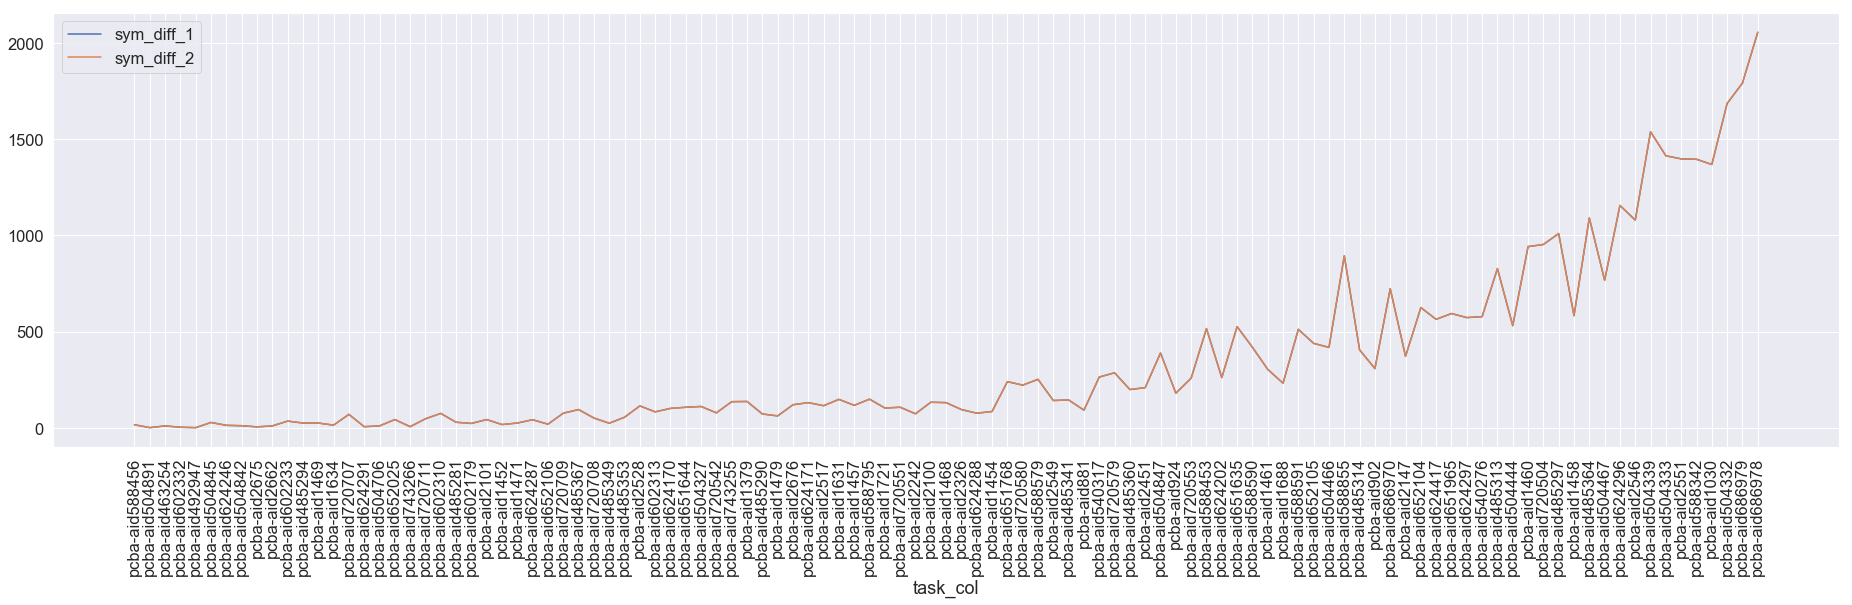

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("paper")
sns.set(font_scale=1.5)

figsize=(32, 8)
plt.figure(figsize=figsize)
sns.lineplot(x=task_means.index, y=task_means['sym_diff_1'].values, sort=False)
sns.lineplot(x=task_means.index, y=task_means['sym_diff_2'].values, sort=False)
plt.xticks(rotation=90);
plt.legend(['sym_diff_1', 'sym_diff_2'])

In [46]:
task_means[['609_hits', '609_UC_hits', '609_qbc_hits', 
            'union_1', 'sym_diff_1', 
            'union_2', 'sym_diff_2', 'active_ratio', 'hit_limit']]

,609_hits,609_UC_hits,609_qbc_hits,union_1,sym_diff_1,union_2,sym_diff_2,active_ratio,hit_limit
task_col,,,,,,,,,
pcba-aid588456,35,21,21,36,16,36,16,0.01,51
pcba-aid504891,2,1,1,2,1,2,1,0.01,34
pcba-aid463254,5,13,13,14,10,14,10,0.01,41
pcba-aid602332,0,3,3,3,3,3,3,0.02,69
pcba-aid492947,2,1,1,2,1,2,1,0.02,80
pcba-aid504845,14,32,32,37,28,37,28,0.03,100
pcba-aid624246,30,21,21,32,13,32,13,0.03,101
pcba-aid504842,30,23,23,32,11,32,11,0.03,101
pcba-aid2675,22,19,19,23,5,23,5,0.04,99


In [9]:
import glob
a = '../../../informer_set_results/cycle_training_data_shape_pkis_6_task_*.txt'
for x in glob.glob(a):
    with open(x, 'r') as f:
        content = f.readlines()
    
    n = int(content[-1].split(', ')[-1][:-1])
    if n != 16:
        print(x)

../../../informer_set_results\cycle_training_data_shape_pkis_6_task_44.txt


In [51]:
x = task_means[['609_hits', '609_UC_hits', '609_qbc_hits', 
            'union_1', 'sym_diff_1', 
            'union_2', 'sym_diff_2', 'active_ratio', 'hit_limit']]

x[x.index.isin(['pcba-aid588456', 'pcba-aid602310', 'pcba-aid1458'])]

,609_hits,609_UC_hits,609_qbc_hits,union_1,sym_diff_1,union_2,sym_diff_2,active_ratio,hit_limit
task_col,,,,,,,,,
pcba-aid588456,35,21,21,36,16,36,16,0.01,51
pcba-aid602310,72,29,29,88,75,88,75,0.08,310
pcba-aid1458,1267,1202,1202,1526,583,1526,583,2.97,5778
